#  Lab 07 Solution - Knowledge Tracing
## Introduction

During the last lectures and lab session, you have dealt into one notable application of machine learning in education, namely knowledge tracing. Machine-learning models optimized for this task aim to understand how well a student is learning a portfolio of skills. Monitoring this knowledge by means of automated models allows to personalize online learning platforms, focusing the assessment on skills the student is weak in and accelerating learning of certain skills.

You are asked to work on the ASSISTment data set presented last week and to complete the following tasks:

- Compare three knowledge tracing models (BKT, AFM, PFA) in terms of AUC and RMSE.
- Generate and discuss the learning curves for a BKT model on a specific set of skills. 

You can use [pyBKT](https://github.com/CAHLR/pyBKT) and [pyAFM](https://github.com/cmaclell/pyAFM/) throughout this tutorial.

In [8]:
# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection, metrics

### YOUR ADDITIONAL IMPORT STATEMENTS BELOW (please, do not make any imports elsewhere in the notebook) ###

# PyBKT package imports
import random
old_randint = random.randint
random.randint = lambda a, b: old_randint(a, int(b))
from pyBKT.models import Model
random.randint = old_randint


## The Data Set
---

ASSISTments is a free tool for assigning and assessing math problems and homework. Teachers can select and assign problem sets. Once they get an assignment, students can complete it at their own pace and with the help of hints, multiple chances, and immediate feedback. Teachers get instant results broken down by individual student or for the whole class. More information on the platform can be found [here](https://www.commonsense.org/education/website/assistments). 

We will play with a simplified version of a dataset collected from the ASSISTments tool, saved in a CSV file with the following columns:  


| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| user_id | The ID of the student who is solving the problem.  | |
| order_id | The temporal ID (timestamp) associated with the student's answer to the problem.  | |
| problem_id | The ID of the problem.  | |
| skill_name | The name of the skill associated with the problem. | |
| correct | The student's performance on the problem: 1 if the problem's answer is correct at the first attempt, 0 otherwise. 
| prior_success | The number of prior problems on that skill the student correctly answered at the first attempt. 
| prior_failure | The number of prior problems on that skill the student wrongly answered at the first attempt.  | |

Load the data set. 

In [9]:
DATA_DIR = "./../../data/"
data = pd.read_csv(DATA_DIR + 'as_hw_cmp.csv')

As a first step, we compute the total number of interactions, the number of unique students, and the number of unique skills. 

In [10]:
len(data.index), len(data['user_id'].unique()), len(data['skill_name'].unique())

(26409, 1014, 3)

We then also take a look at the skills included in the data set. 

In [11]:
data['skill_name'].unique()

array(['Circle Graph', 'Venn Diagram', 'Mode'], dtype=object)

Finally, we show the first ten rows of the data dataframe, to have an idea of how the data looks like. 

In [12]:
data.head(20)

,user_id,order_id,problem_id,skill_name,correct,prior_success,prior_failure
0,14,21617623,93383,Circle Graph,0,0,0
1,14,21617632,93407,Circle Graph,1,0,1
2,14,21617641,93400,Circle Graph,0,1,1
3,14,21617650,93419,Circle Graph,0,1,2
4,14,21617659,93420,Circle Graph,0,1,3
5,14,21617667,93415,Circle Graph,0,1,4
6,14,21617675,93423,Circle Graph,0,1,5
7,14,21617692,57695,Circle Graph,0,1,6
8,14,21617731,58596,Circle Graph,1,1,7
9,14,21617749,57647,Circle Graph,0,2,7


<a id="section1"></a>
## 1  Knowledge Tracing: Model Performance Comparison 
----

In this section, we ask you to evaluate (i) a Bayesian Knowledge Tracing (BKT) model, (ii) an Additive Factor Model (AFM), and (iii) a Performance Factor Analysis (PFA) model on the skills 'Circle Graph', 'Venn Diagram', and 'Mode', by performing a user-stratified 10-fold cross validation and monitoring the Root Mean Squared Error (RMSE) and the Area Under the ROC Curve (AUC) as performance metrics. Then, we ask you to visually report the RMSE and AUC scores achieved by the three student's models in the user-stratified 10-fold cross validation, in such a way that the models' performance can be easily and appropriately compared against each other.

For your convenience, you will be guided in completing this section through seven main tasks:
- Task 1.1: Group k-fold initialization.
- Task 1.2: BKT evaluation.
- Task 1.3: AFM evaluation.
- Task 1.4: PFA evaluation.
- Task 1.5: Performance metrics plotting.
- Task 1.6: Performance metrics discussion. 

<a id="section1.1"></a>
### Task 1.1

Given that the main objective of this homework section is to evaluate three student's knowledge tracing models under a `user-stratified 10-fold cross validation`, in this task, we ask you to complete the body of a function named `create_iterator`. This function should create an iterator object able to split student's interactions included in `data` in `10 folds` such that the same student does not appear in two different folds. To do so, you can appropriately initialize a scikit-learn's GroupKFold iterator with non-overlapping groups and returning the iterator, i.e., `model_selection.GroupKFold(...).split(...)`. 

For convenience, we present you an illustrative example assuming that (i) you have four data samples and that (ii) the first two data samples belong to group 0 and the last two data samples belong to group 2. The data samples associated with a group should not appear in multiple folds or, in other words, the data samples associated with a group should appear all in the same fold. Please, find below a way to use the scikit-learn's GroupKFold object to create folds that meet this property (here, we simulate this scenario by considering only a 2-fold creation strategy):

`X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 3, 4])
groups = np.array([0, 0, 2, 2])
group_kfold = model_selection.GroupKFold(n_splits=2).split(X, y, groups)
`

Finally, we provide an illustrative example not related with the task on how this iterator can be then used to generate training and test folds:

`
for train_index, test_index in group_kfold:
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, '-', X_test, '-', y_train, '-', y_test)
`

The above for loop generates the following output. It can be observed that the data samples belonging to a group all appear in the same fold, as expected. 

`TRAIN: [0 1] TEST: [2 3]
[[1 2] [3 4]] - [[5 6] [7 8]] - [1 2] - [3 4] 
`

`
TRAIN: [2 3] TEST: [0 1]
[[5 6] [7 8]] - [[1 2] [3 4]] - [3 4] - [1 2]
`

Please, find more information about the GroupKFold iterator in the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) documentation.

In [13]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data in 10 folds, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''
    ### YOUR CODE HERE ###
    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupKFold(n_splits=10).split(X, groups=groups)

Let's check the output of this function and a few properties of the iterator. 

In [14]:
tested_user_ids = set()
for iteration, (train_index, test_index) in enumerate(create_iterator(data)):
    user_ids = data['user_id'].unique()
    train_user_ids = data.iloc[train_index]['user_id'].unique()
    test_user_ids = data.iloc[test_index]['user_id'].unique()
    print('Iteration:', iteration)
    print('Intersection between train and test user ids:', set(train_user_ids) & set(test_user_ids))
    print('All user ids in train and test user union:', len(set(train_user_ids).union(set(test_user_ids))) == len(user_ids))
    print('User ids tested more than once:', set(tested_user_ids) & set(test_user_ids))
    tested_user_ids = tested_user_ids.union(set(test_user_ids))
    print()

Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 1
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 2
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 3
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 4
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 5
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 6
Intersection between train and test user ids: set()
All user ids in train a

In [15]:
len(tested_user_ids) == len(user_ids)

True

On a given iteration, no user appears in both training and test sets. The union of the users in both training and test sets given us the full set of user ids in the dataset. Each user appears in the test set exactly once.  

<a id="section1.2"></a>
### Task 1.2

In this task, we ask you to evaluate a `BKT model` with all default parameters, namely `Model(seed=0)` in pyBKT, through a `10-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`. To do so, you should use the `create_iterator` function, defined in Task 1.2, to create the training and test set for each fold, starting from the interactions in `data`. 

No plotting is needed, it is enough to print the scores for each metric in the cell.

Please, note that this task may require a long running time (e.g., about 40 to 90 minutes), depending on your implementation. Just as an indication, on a Dell XPS 13, one fold lasts around 7 minutes.  

In [16]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
rmse_bkt, auc_bkt = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(data)):
    # Split data in training and test sets
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    # Initialize and fit the model
    model = Model(seed=0)
    %time model.fit(data=X_train) 
    # Compute RMSE
    train_rmse = model.evaluate(data=X_train, metric='rmse')
    test_rmse = model.evaluate(data=X_test, metric='rmse')
    rmse_bkt.append(test_rmse)
    # Compute AUC
    train_auc = model.evaluate(data=X_train, metric='auc')
    test_auc = model.evaluate(data=X_test, metric='auc')
    auc_bkt.append(test_auc)
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

CPU times: user 13.4 s, sys: 60.7 ms, total: 13.4 s
Wall time: 6.71 s
Iteration: 0 RMSE (0.3621871835386822, 0.37127163604349117) AUC (0.8737905181943224, 0.8791831722551088)
CPU times: user 7.24 s, sys: 27.3 ms, total: 7.26 s
Wall time: 3.66 s
Iteration: 1 RMSE (0.362695341903765, 0.3645523047281563) AUC (0.8767550760595797, 0.8501502627239993)
CPU times: user 9.44 s, sys: 98.3 ms, total: 9.54 s
Wall time: 4.8 s
Iteration: 2 RMSE (0.3633245192704351, 0.3629302950091262) AUC (0.8758387739502046, 0.8700078141649501)
CPU times: user 7.4 s, sys: 33.3 ms, total: 7.43 s
Wall time: 3.78 s
Iteration: 3 RMSE (0.36325063417884673, 0.3640795356718709) AUC (0.873547253368891, 0.88408007445119)
CPU times: user 9.8 s, sys: 73 ms, total: 9.87 s
Wall time: 4.98 s
Iteration: 4 RMSE (0.3618964376913986, 0.38660088355117705) AUC (0.8754667172984836, 0.8811410934793463)
CPU times: user 4.24 s, sys: 9.8 ms, total: 4.25 s
Wall time: 2.15 s
Iteration: 5 RMSE (0.3625703675107069, 0.37258954929772337) AUC (0.

Finally, we show the mean and the standard deviation of the RMSE and AUC across folds. 

In [17]:
'RMSE', np.mean(rmse_bkt), np.std(rmse_bkt)

('RMSE', 0.36382543208348217, 0.01112652736103641)

In [18]:
'AUC', np.mean(auc_bkt), np.std(auc_bkt)

('AUC', 0.873573308354373, 0.015719254300566393)

<a id="section1"></a>
## 2  Knowledge Tracing: Learning Curves Comparison 
----

In this section, you should fit a Bayesian Knowledge Tracing (BKT) model on the three skills included in the `data` data set, and compute the corresponding predictions. Then, for each skill included in the data dataframe, you should visually report and discuss (i) the learning curve and (ii) the bar plot representing the number of students who reached a given number of opportunities for that skill,  obtained with the BKT model fitted on the above-mentioned skills, in such a way that they can be easily and appropriately compared. No comparison with other baseline model is required.

For your convenience, you will be guided in completing this section through three main tasks:
- Task 2.1: BKT fit and prediction. 
- Task 2.2: Learning curves and bar plots generation.
- Task 2.3: Learning curves and bar plots discussion. 

<a id="section2.1"></a>
### Task 2.1

In this task, we ask you to fit a BKT model with all default parameters, i.e., `Model(seed=0)` in pyBKT, on the full `data` data set (no split into train and test set needed as we are not assessing predictive performance of the model here). Once you BKT model is fitted, we ask you to create a dataframe named `predictions` with four columns `user_id`, `skill_name`, `y_true`, `y_pred_bkt`. This dataframe should include one row per interaction in `data`, where user_id is the id of the student associated with that interaction, skill_name is the name of the skill involved in that interaction, y_true is the student's performance on that interaction (1 if correct at the first attempt, 0 otherwise), and y_pred_bkt is the prediction made by the pre-trained BKT model for that interaction.  

Please, note that this task may require a long running time (e.g., about 10 to 20 minutes), depending on your implementation. Just as an indication, on a Dell XPS 13, the fit process lasts around 7 minutes.  

In [32]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###

# Initialize the model
model = Model(seed=0)

# Fit the model on the entire dataset
%time model.fit(data=data)

CPU times: user 5.59 s, sys: 21.7 ms, total: 5.61 s
Wall time: 2.82 s


In [33]:
# Make predictions
predictions = model.predict(data=data)[['user_id', 'skill_name', 'correct', 'correct_predictions']]

# Rename the dataframe columns as per instructions
predictions.columns = ['user_id', 'skill_name', 'y_true', 'y_pred_bkt']

As a double check, we show the first ten rows of the predictions dataframe.

In [34]:
predictions.head()

,user_id,skill_name,y_true,y_pred_bkt
0,14,Circle Graph,0,0.47176
1,14,Circle Graph,1,0.34254
2,14,Circle Graph,0,0.57597
3,14,Circle Graph,0,0.45804
4,14,Circle Graph,0,0.33064


<a id="section2.4"></a>
### Task 2.2

In this task, for each skill, we ask you to visually report and discuss (i) the `learning curve` and (ii) the `bar plot` representing the number of students who reached a given number of opportunities (similar to the visualizations done in Tutorial 6),  obtained by the BKT model fitted on that skill, in such a way that they can be easily and appropriately compared. To do so, we ask you to use the predictions you stored in the dataframe `predictions`.    

No comparison with other baseline model is required.

Please, refer to Tutorial 6 for further information on learning curve and bar plotting for student's knowledge tracing models.

In [35]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
def avg_y_by_x(x, y):
    # Transform lists into arrays
    x = np.array(x)
    y = np.array(y)

    # Sort the integer id representing the number of opportunities in increasing order
    xs = sorted(list(set(x)))

    # Supporting lists to store the:
    # - xv: integer identifier of the number of opportunities
    # - yv: average value across students at that number of opportunities
    # - lcb and ucb: lower and upper confidence bound
    # - n_obs: number of observartions present at that number of opportunities (on per-skill plots, it is the #students)
    xv, yv, lcb, ucb, n_obs = [], [], [], [], []

    # For each integer identifier of the number of opportunities 0, ...
    for v in xs:
        ys = [y[i] for i, e in enumerate(x) if e == v] # We retrieve the values for that integer identifier
        if len(ys) > 0: 
            xv.append(v) # Append the integer identifier of the number of opportunities
            yv.append(sum(ys) / len(ys)) # Append the average value across students at that number of opportunities
            n_obs.append(len(ys)) # Append the number of observartions present at that number of opportunities

            
            # Prepare data for confidence interval computation
            unique, counts = np.unique(ys, return_counts=True)
            counts = dict(zip(unique, counts))

            if 0 not in counts:
                counts[0] = 0
            if 1 not in counts:
                counts[1] = 0

            # Calculate the 95% confidence intervals
            ci = sc.stats.beta.interval(0.95, 0.5 + counts[0], 0.5 + counts[1])
            lcb.append(ci[0])
            ucb.append(ci[1])

    return xv, yv, lcb, ucb, n_obs

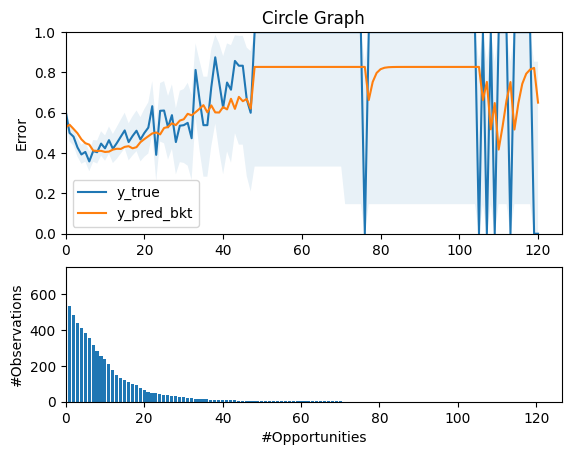

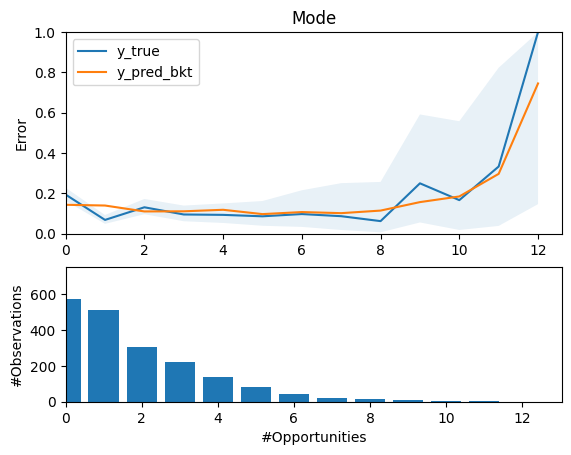

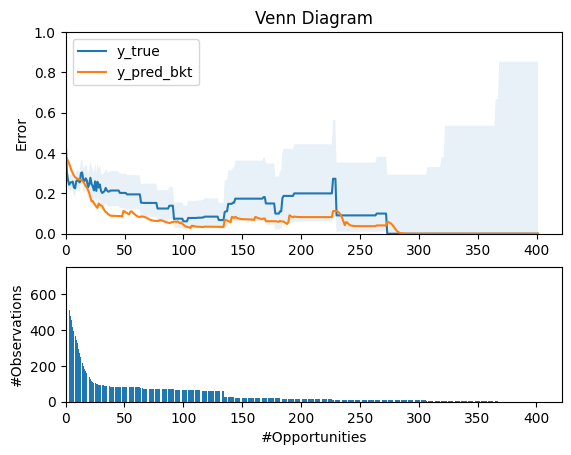

In [36]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###

for plot_id, skill_name in enumerate(data['skill_name'].unique()): # For each skill under consideration
    
    preds = predictions[predictions['skill_name'] == skill_name] # Retrieve predictions for the current skill

    xp = []
    yp = {}
    for col in preds.columns: # For y_true and and y_pred_bkt columns, initialize an empty list for curve values
        if 'y_' in col:
            yp[col] = []

    for user_id in preds['user_id'].unique(): # For each user
        user_preds = preds[preds['user_id'] == user_id] # Retrieve the predictions on the current skill for this user 
        xp += list(np.arange(len(user_preds))) # The x-axis values go from 0 to |n_opportunities|-1
        for col in preds.columns: 
            if 'y_' in col: # For y_true and and y_pred_bkt columns
                yp[col] += user_preds[col].tolist() # The y-axis value is the success rate for this user at that opportunity

    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}) # Initialize the plotting figure

    lines = []
    for col in preds.columns:
        if 'y_' in col: # For y_true and and y_pred_bkt columns   
            x, y, lcb, ucb, n_obs = avg_y_by_x(xp, yp[col]) # Calculate mean and 95% confidence intervals for success rate 
            y = [1-v for v in y] # Transform success rate in error rate
            if col == 'y_true': # In case of ground-truth data, we also show the confidence intervals
                axs[0].fill_between(x, lcb, ucb, alpha=.1)
            model_line, = axs[0].plot(x, y, label=col) # Plot the curve
            lines.append(model_line) # Store the line to then set the legend    

    # Make decorations for the learning curve plot
    axs[0].set_title(skill_name)
    axs[0].legend(handles=lines)
    axs[0].set_ylabel('Error')
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(0, None)

    # Plot the number of observations per number of opportunities bars and make decorations
    axs[1].set_xlabel('#Opportunities')
    axs[1].bar([i for i in range(len(n_obs))], n_obs)
    axs[1].set_ylabel('#Observations')
    axs[1].set_ylim(0, 750)
    axs[1].set_xlim(0, None)

    # Plot the learning curve and the bar plot 
    plt.show()

### Task 2.3 Please discuss all visualizations (learning curves and bar plots) obtained with the BKT model. 

First, we discuss each skill separately. Then, given that we are showing the same aspects for the three skills, we provide few more observations aimed at comparing the findings we obtained across the skills under consideration. 

- "**Circle Graph**". From the error rate in the ground-truth data (y_true, blue), it can be observed that this skill appears quite hard for students, with an initial error rate of around 0.60 in the first opportunity. The error rate goes slightly down, as we would usually expect, as much as the students play with the skill, reaching the lowest error rate of 0.38 at around 7 opportunities. However, starting from #opportunities around equal to 7, the error rate starts going up till 0.80 after 50 opportunities. It seems that a large part of the students managed to master a bit this skill in the first opportunities, but then they start facing difficulties in mastering it. This behavior might be due to the fact that the skill is ill-defined or that the problems become too difficult or are not aligned well with the skill.  After 50 opportunities, the error rate starts jumping between 0 and a 1 just because there are only few students. In terms of confidence interval (blue area), it can be observed that the error rate is quite stable at the earlier stage. Starting from around 7 opportunities, the error rate is less stable probably due to the same reasons we provided above. The confidence interval finally becomes large when only few students keep playing with this skill for a higher number of opportunities. When it comes to consider the error rate obtained by the BKT model estimations (y_pred_bkt, orange), it can be observed that the model tends to overestimate a bit the error rate during the first opportunities (the orange line is above the blue one, the model tends to predict more errors than expected), while the opposite pattern is observed for higher numbers of opportunities (the model tends to predict less errors than expected). However, in general, the model fits well the ground-truth data. Looking at the bar plot at the bottom, students appear reasonably engaged with this skill only for few opportunities (particularly, starting from 35 opportunities, the number of involved students is low, and the error rate starts jumping more).            

- "**Mode**". Based on the patterns of the ground-truth data (y_true, blue), the error rate observed for this skill at the earlier stages is of around 0.20. The students thus are already good in problems involving this skill, somehow. While this might depend on the intrinsic knowledge/background of the students about this skill, this behavior might also appear due to the fact that the skill is easier and easier to master in general or that the problems presented to the students on that skill are too easy, for instance. While the error rate goes slightly down when the number of opportunities increases, the difference between the initial error rate and the error rate experienced (for instance) after 5 or 6 opportunities is relatively small (around 0.10 of error rate in the latter case). This observation might be justified by the fact that students played with the skill only for few opportunities (so there is no so much room for improving more) and by the already low initial error rate (students might use those opportunities just to refine their knowledge, with few errors still happening). The going-up behavior at the end appears mainly due to the very low number of students involved at that point. The blue area shows us that the confidence interval is very small for the first three or four opportunities (so behavior is more consistent among students), while it starts increasing later probably also due to the peculiar patterns behind students who interact more with this skill. The BKT model (y_pred_bkt, orange) is able to fit the ground-truth data very well across the number of opportunities, especially till around 8 opportunities. One important observation comes from the bar plot, which shows that the number of students involved in this skill drastically goes down especially after three/four opportunities.     

- "**Venn Diagram**". This third skill appears like another somehow easy skill since the beginning (y_true, blue), but a bit more harder than "Mode". Except for a few fluctuations in the very first opportunities (where the curve slightly increases, maybe because they are just the first opportunities or due to the type/difficulty of problems proposed at that point), the error rate goes down till around 0.08, reached at around 100 opportunities. Probably, once only those students struggling more with this skill tend to stay for a higher number of opportunities, the error rate goes up again. The confidence interval for the ground-truth data (blue area) is relatively high (if compared with the one observed for the other two skills during the first opportunities). Naturally, it increases even more when the number of students reaching that number of opportunities is very low (#opportunities > 130). Comparing the ground-truth estimations with the BKT estimations (y_pred_bkt, orange), except for the first opportunities, it can be observed that BKT tends to consistently underestimate the error rate and the BKT error rate is often outside the confidence interval of actual data. The number of students per opportunity naturally goes down as observed for the other skills, but interestingly it can be observed that a set of students seems to still keep playing with this skill from around 30 opportunites till 100 opportunities stably (the bar plot values appear somehow similar in that range).  

Overall, comparing the considered three skills, "Circle Graph" seems to be really going up (e.g., ill-defined skill or due to the type/difficulty of problems), while, for "Mode" and "Venn Diagram", the going up later seems to come only from the very low number of students. Especially but not only for the "Venn Diagram" skill, the BKT generally tends to under-estimate the error rate. One reason behind this observation could be that the BKT model we adopted did not consider forgetting, for instance. In terms of number of opportunities, students experienced a lower maximum number of opportunities on the "Mode" skill, compared to the others. Compared to "Circle Graph", the skill "Venn Diagram" seems to involve lots of students even for higher number of opportunities (e.g., #opportunities > 30).   